In [1]:
# Imports
# all imports and helper functions are in config file
from config import *

In [2]:
# Constructing Dataset

cw = context_width
dw = decision_width
pw = (cw-dw)//2 # padding width

X, y = [], []


# getting tif files
xpath = 'data/raw_labeled_data/images'
xfiles = [f for f in os.listdir(xpath) if f.endswith('.tif')]

ypath = 'data/raw_labeled_data/annotations'
yfiles = [f for f in os.listdir(ypath) if f.endswith('.tif')]

samples_per_file = samples//len(xfiles)


# for each image, get random x and y patches.
for xfile, yfile in zip(xfiles, yfiles):

    # open input image as tensor
    xpath = os.path.join('data/raw_labeled_data/images', xfile)
    xsource = rio.open(xpath)
    
    xmat = xsource.read() # 3d array w/ shape = (bands=8, height, width)
    xmat = np.pad(xmat, pad_width=((0, 0), (pw, pw), (pw, pw)), mode='edge') #pad for context width
    xmat = xmat.transpose(1, 2, 0) # change to (height, width, bands=8)

    # open label image as tensor
    ypath = os.path.join('data/raw_labeled_data/annotations', yfile)
    ysource = rio.open(ypath)

    ymat = ysource.read()
    ymat = ymat.transpose(1, 2, 0)

    # save random patches from tensor
    for _ in range(samples_per_file):
        i = np.random.randint(0, len(ymat)-dw)
        j = np.random.randint(0, len(ymat[0])-dw)
        xpatch = xmat[i:i+cw, j:j+cw, :]
        ypatch = ymat[i:i+dw, j:j+dw, :]
        X.append(xpatch)
        y.append(ypatch)


X = np.array(X)
y = np.array(y)

print(f'Dataset loaded with {len(X)} samples')
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

Dataset loaded with 1998 samples
X shape: (1998, 16, 16, 8)
y shape: (1998, 16, 16, 1)


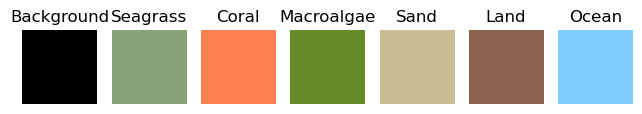

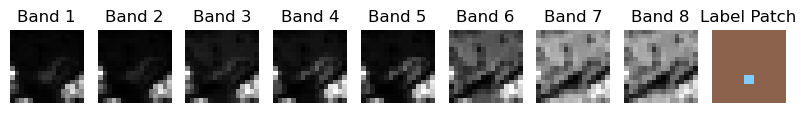

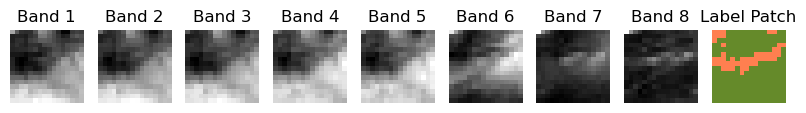

In [3]:
# Visualization

show_class_colors() #show color legend

# show random patches from the dataset
for _ in range(2):
    i = np.random.randint(0, len(X)) #random index
    xpatch = X[i]
    ypatch = y[i]
    
    # map colors for labels
    yimg = np.zeros((ypatch.shape[0], ypatch.shape[1], 3), dtype=np.uint8)
    for i in range(ypatch.shape[0]):
        for j in range(ypatch.shape[1]):
            yimg[i, j] = classColors[ypatch[i, j, 0]]
    

    plt.figure(figsize=(10, 5))

    for band in range(8):
        plt.subplot(1, 9, band+1)
        plt.imshow(xpatch[:, :, band], cmap='gray')
        plt.title(f'Band {band+1}')
        plt.axis('off')

    plt.subplot(1, 9, 9)
    plt.imshow(yimg)
    plt.title('Label Patch')
    plt.axis('off')
    plt.show()

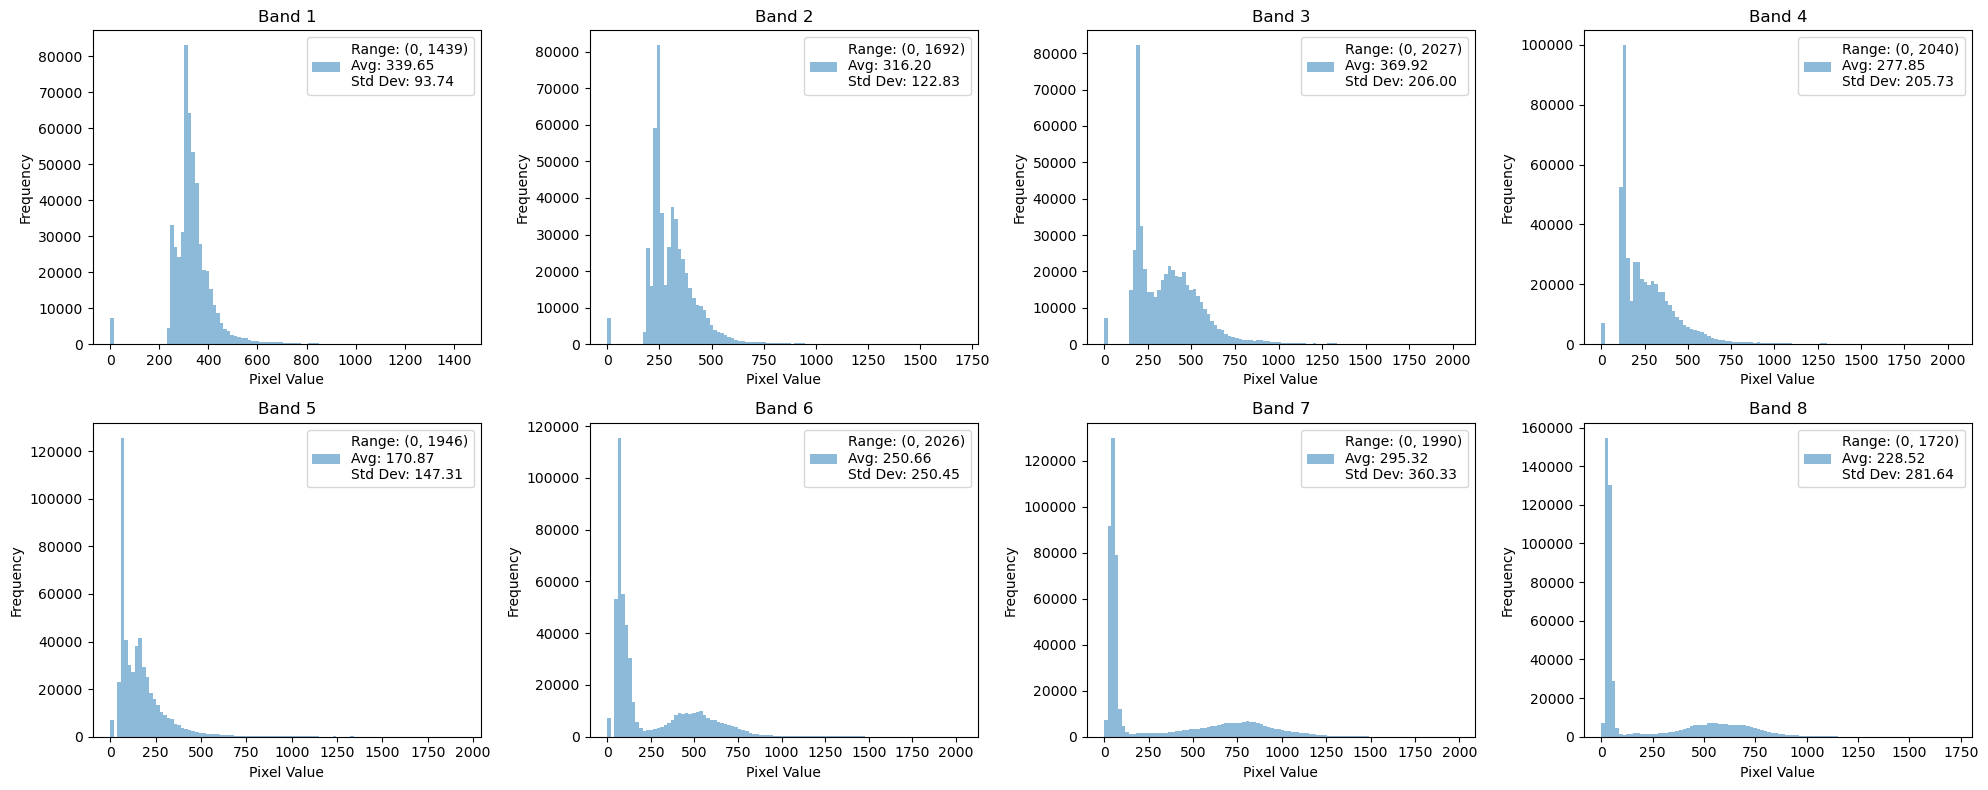

In [4]:
# Band Distribution Analysis
ranges = []
averages = []
stddevs = []

plt.figure(figsize=(20, 8))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.hist(X[:, :, :, i].flatten(), bins=100, alpha=0.5, label=f'Band {i+1}')
    ranges.append((int(X[:, :, :, i].min()), int(X[:, :, :, i].max())))
    averages.append(X[:, :, :, i].mean())
    stddevs.append(X[:, :, :, i].std())

    plt.legend([f'Range: {ranges[i]}\nAvg: {averages[i]:.2f}\nStd Dev: {stddevs[i]:.2f}'], loc='upper right')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.plot()

    plt.title(f'Band {i+1}')
plt.tight_layout()
plt.show()

In [5]:
# Save Dataset

# delete all patches in the dataset folder
for f in os.listdir('data/dataset/X'):
    os.remove(os.path.join('data/dataset/X', f))

for f in os.listdir('data/dataset/y'):
    os.remove(os.path.join('data/dataset/y', f))

# save all patches as tif files
for i in range(len(X)):
    xpatch = X[i].astype(np.float32)
    ypatch = y[i].astype(np.uint8)

    xpatch_path = os.path.join('data/dataset/X', f'patch_{i}.tif')
    ypatch_path = os.path.join('data/dataset/y', f'patch_{i}.tif')
    with rio.open(xpatch_path, 'w', driver='GTiff', height=xpatch.shape[0], width=xpatch.shape[1], count=xpatch.shape[2], dtype='float32') as dst:
        dst.write(xpatch.transpose(2, 0, 1))
    with rio.open(ypatch_path, 'w', driver='GTiff', height=ypatch.shape[0], width=ypatch.shape[1], count=ypatch.shape[2], dtype='uint8') as dst:
        dst.write(ypatch.transpose(2, 0, 1))